In [9]:
import nibabel as nib
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

In [ ]:
### Apply coregistration transformation on FMRI sequence to bring it to T1-space. ###

import subprocess

# Define file paths
root = '/home/mondal/Desktop/MyFiles/'
pca_in_file = "/data/NSSP_Project1_TeamP/home/joyvan/Data/group_project/moco_smoothed-4mm.nii.gz"          # fMRI volume to conduct PCA
ref_file = "/data/data/subject101410/T1w/T1w_brain.nii.gz"         # T1 image (same as used in epi_reg)
mat_file = "/data/NSSP_Project1_TeamP/home/joyvan/Data/group_project/coreg/moco_vol_bbr.mat"        # affine transform from epi_reg
out_file = "/data/NSSP_Project1_TeamP/home/joyvan/Data/group_project/coreg_moco_smoothed-4mm.nii.gz"        # output filename

# Build flirt command
flirt_cmd = [
    "flirt",
    "-in", pca_in_file,
    "-ref", ref_file,
    "-applyxfm",
    "-init", mat_file,
    "-out", out_file,
    "-interp", "trilinear"
]

# Run the command
subprocess.run(flirt_cmd, check=True)

print(f"Transformation applied. Output saved to: {out_file}")
# Use FMRI saved to out_file to conduct PCA

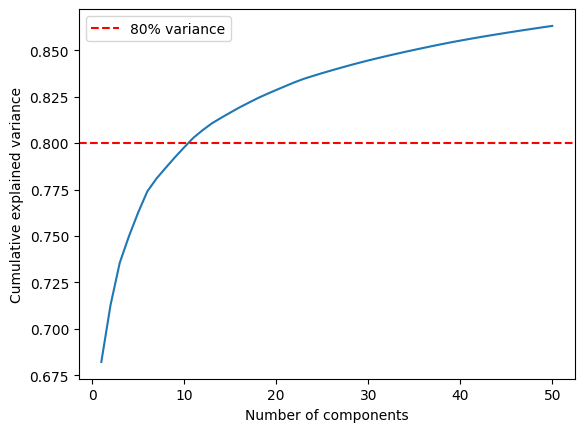

In [ ]:
import matplotlib.pyplot as plt

explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(explained)+1), explained)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(0.8, color='r', linestyle='--', label='80% variance')
plt.legend()
plt.show()

# Choose x components, if they cumulatively explain >80% variance
#n_components = 10, explains 80% of the variance :)


In [ ]:
# Load 4D fMRI data for one subject & run (shape = X, Y, Z, T)
img = nib.load("C:/Users/kslif/Downloads/moco_smoothed-4mm.nii.gz") #passing preprocessed data

fmri_data = img.get_fdata() #(91, 109, 91, 568))

# Transpose to shape: n_timepoints x n_voxels (samples x features)
X = fmri_data.reshape(-1, fmri_data.shape[-1]).T.astype('float32')  #(568, 902629)

# Standardize each voxel's time series
scaler = StandardScaler()
X_z = scaler.fit_transform(X)

# Run PCA
#pca = PCA()
#X_pca = pca.fit_transform(X_z)

pca = IncrementalPCA(n_components=50)
X_pca = pca.fit_transform(X_z)  #(568, 50)

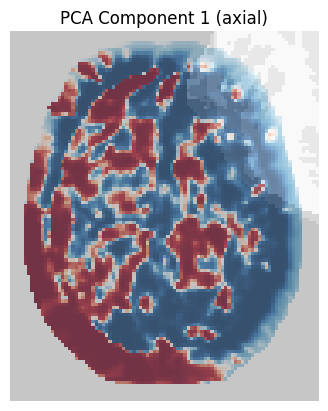

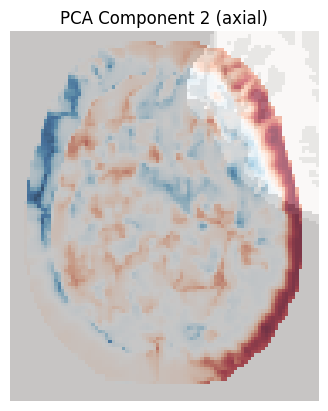

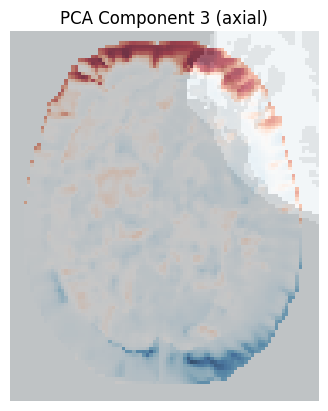

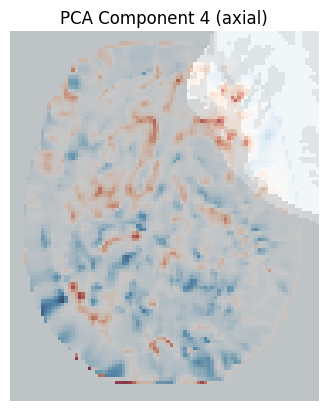

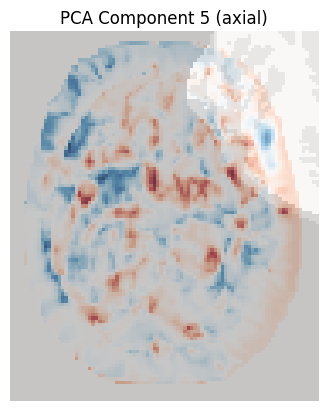

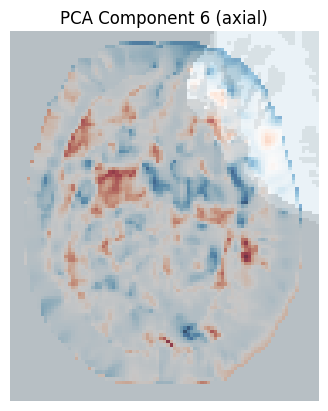

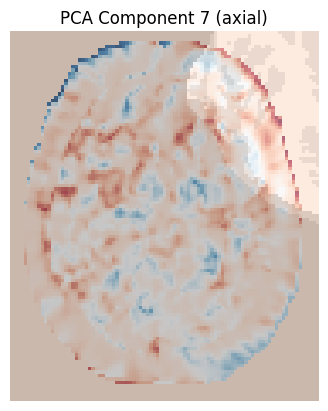

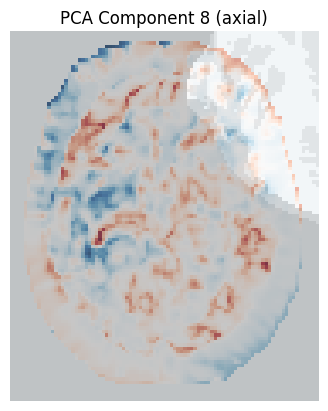

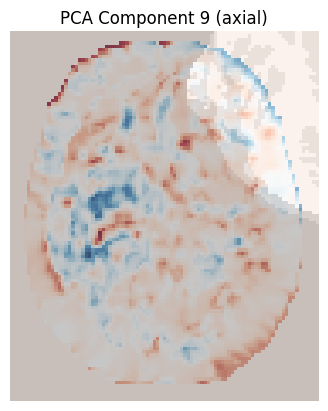

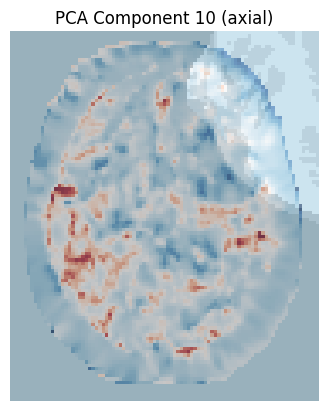

In [ ]:
#Visualize Each Component (Axial view on anatomy)
#Each PCA component is a vector of voxel weights; you can reshape to the original 3D shape (using mask) for visualization.
#Overlap onto an anatomical template and plot.

import matplotlib.pyplot as plt

anatomy = nib.load('C:/Users/kslif/Downloads/T1w_fast_pveseg.nii.gz').get_fdata()  # background for display
n_components=10

for comp_idx in range(n_components):
    weights = pca.components_[comp_idx].reshape(fmri_data.shape[:3])  # (x, y, z)
    idx = weights.shape[2] // 2  # Choose the central axial slice
    plt.figure()
    plt.imshow(anatomy[:, :, idx].T, cmap='gray', alpha=0.5, origin='lower')
    plt.imshow(weights[:, :, idx].T, cmap='RdBu_r', alpha=0.8, origin='lower')
    plt.title(f'PCA Component {comp_idx+1} (axial)')
    plt.axis('off')
    plt.show()


In [ ]:
#Compute Pairwise Similarity Matrix for First 5 Components

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# Extract first 5 components' spatial maps
comp_maps = pca.components_[:5]

# Compute similarity (correlation) matrix
n = comp_maps.shape[0]
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        sim_matrix[i, j] = pearsonr(comp_maps[i], comp_maps[j])[0]

print('Pairwise similarity (correlation) matrix of first 5 components:')
print(sim_matrix)